In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# EVITEN EL PLAGIO #

***En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet siempre y cuando no se usen para resolver explicitamente lo que el ejercicio pide implementar.***

***Si eligen utilizar código sacado de interenet es necesario agregar el link en comentarios de donde fue sacado ese código.***



# Parte 1 - Descripción de la Tarea
En esta sección vamos a armar una imágen panorama basada en 5 imágenes de la misma escena. Las imagenes se encuantran en la carpeta `images` y son las siguientes: 




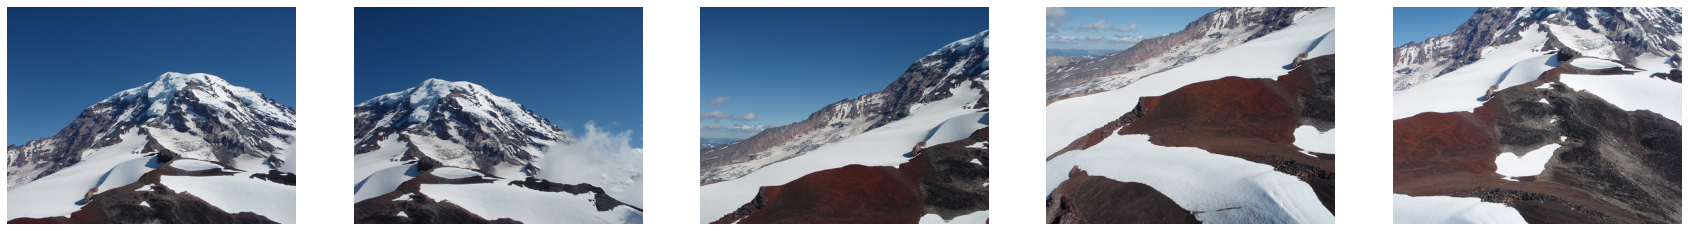

Para generar la imagen panorama global es necesario seguir los siguientes pasos:

1. Utilizar cualquiera de las funciones de OpenCV para extraer puntos de interes y descriptores.
2. Implementar su propia función de matching de puntos (`match_points`) basada en nearest neighbours y agregar todas las posibles mejoras vistas en clase para que el algoritmos sea más robusto.
3. Analizar las imágenes de a pares y calcular la **transformación afìn**  que mapea cada una de lás imagenes con la imagen más cercana. Implementar las funciones para calcular la transformación de una imagen y hacerlo de forma robusta utilizando RANSAC.
4. Armar la imágen panorama alineando la secuencia de imágenes correctamente. El orden de la secuenciá de imágenes es como se ve en la imagen anterior de izquierda a derecha. Los archivos están ordenados por nombre: `Rainier1.jpg` , `Rainier2.jpg`, `Rainier3.jpg`, `Rainier4.jpg`, `Rainier5.jpg`

5. Modificar las funciones anteriores para poder calcular una homografía en vez de una transformación afín y tener resultados de alineación más exactos.

### Resultado Final
El resultado final debería verse similar a la imagen siguiente:

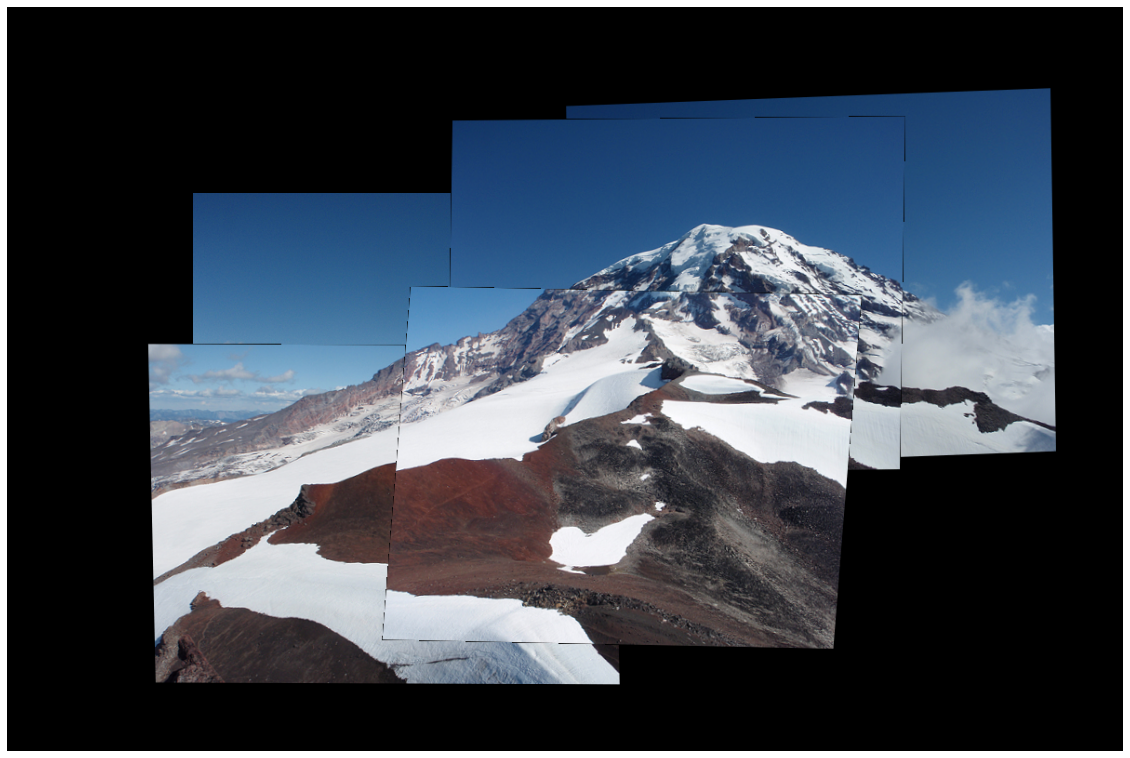

In [53]:
def distancia(dato1, dato2):
    distancia = 0
    for x in range(len(dato1)):
        distancia += np.square(dato1[x] - dato2[x])
    return np.sqrt(distancia)


def encontrar_pares(set1, set2):
    indices1 = []
    indices2 = []
    dist = 0
    punto = 0
    #saco los mas chicos respecto al set1
    for i in range(len(set1)):
        min = np.inf

        for j in range(len(set2)):
            dist = np.linalg.norm(set1[i] - set2[j])
            if dist < min:
                min = dist
                punto = j
        indices1.append(punto)

    #saco los mas chicos respecto al set1
    for j in range(len(set2)):
        min = np.inf
        for i in range(len(set1)):
            dist = np.linalg.norm(set1[i] - set2[j])
            if dist < min:
                min = dist
                punto = i
        indices2.append(punto)

    pares = []

    #corroborar que los mas chicos del primero sea los mas chicos del 2
    for i in range(len(indices1)):
        if i == indices2[indices1[i]]:
            pares.append((i, indices1[i]))

    return pares


def filtrar_umbral(indices, des1, des2, umbral):
    pares = []
    for indice in indices:
        if np.linalg.norm(des1[indice[0]] - des2[indice[1]]) < umbral:  #aca definimos el treshold
            pares.append((indice[0], indice[1]))
    return pares


def comparar(elemento):
    return elemento[1]


def filtrar_cantidad(indices, des1, des2, cantidad):
    aux = []
    for i in range(len(indices)):
        aux.append((indices[i], np.linalg.norm(des1[indices[i][0]] - des2[indices[i][1]])))

    aux.sort(key=comparar)
    mejores = []
    for j in range(cantidad):
        mejores.append(aux[j])

    return mejores



def encontrar_Homografia(indices,kp_2, kp_1):

    H=RANSAC(indices,kp_2, kp_1,1000,4,0.05)
    return H

def RANSAC(indices,kp_2, kp_1,iter,size,threshold_distance):
    num = len(indices)
    pts_1 = np.float32([kp_1[m[0]].pt for m in indices])
    pts_2 = np.float32([kp_2[m[1]].pt for m in indices])

    best_result = 0
    point1_hold = []
    point2_hold = []

    for i in range(0,iter):

        index = np.random.randint(0,num,size)
        valores_homografia=[(indices[t],1) for t in index]
        try:
            transform_matrix_tmp =generar_matriz(valores_homografia,kp_2, kp_1)
        except:
            continue
        point2_transormed = [np.dot(transform_matrix_tmp,np.append(punto,1))for punto in pts_2]

        point2_transormed=[np.array([i[0]/i[2],i[1]/i[2]])for i in point2_transormed]

        distances=np.sqrt(np.sum((point2_transormed-pts_1)**2,axis=1))
        num_inliers = distances[distances < threshold_distance].shape[0]

        if num_inliers == 0:
            continue

        if i == 0:
            best_result = num_inliers
            index_inliers = np.argwhere(distances<threshold_distance).flatten()
            point1_hold = pts_1[index_inliers,:]
            point2_hold = pts_2[index_inliers,:]


        if best_result < num_inliers:

            best_result = num_inliers
            index_inliers = np.argwhere(distances<threshold_distance).flatten()
            point1_hold = pts_1[index_inliers,:]
            point2_hold = pts_2[index_inliers,:]

            valores_homografia=[(indices[t],1) for t in index]
            transform_matrix =generar_matriz(valores_homografia,kp_2, kp_1)


    return transform_matrix





def generar_matriz(valores_homografia,kp_2, kp_1):
    xi = [t[0][0] for t in valores_homografia]
    yi = [t[0][1] for t in valores_homografia]

    kp1h = [kp_1[i] for i in xi]
    kp2h = [kp_2[i] for i in yi]

    x1 = [t.pt[0] for t in kp1h]
    y1 = [t.pt[1] for t in kp1h]

    x = [t.pt[0] for t in kp2h]
    y = [t.pt[1] for t in kp2h]

    P = np.array([
            [-x[0], -y[0], -1, 0, 0, 0, x[0] * x1[0], y[0] * x1[0], x1[0]],
              [0, 0, 0, -x[0], -y[0], -1, x[0] * y1[0], y[0] * y1[0], y1[0]],
              [-x[1], -y[1], -1, 0, 0, 0, x[1] * x1[1], y[1] * x1[1], x1[1]],
              [0, 0, 0, -x[1], -y[1], -1, x[1] * y1[1], y[1] * y1[1], y1[1]],
              [-x[2], -y[2], -1, 0, 0, 0, x[2] * x1[2], y[2] * x1[2], x1[2]],
              [0, 0, 0, -x[2], -y[2], -1, x[2] * y1[2], y[2] * y1[2], y1[2]],
              [-x[3], -y[3], -1, 0, 0, 0, x[3] * x1[3], y[3] * x1[3], x1[3]],
              [0, 0, 0, -x[3], -y[3], -1, x[3] * y1[3], y[3] * y1[3], y1[3]],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]])

    b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1])
    Pt = np.transpose(P)
    PtP = np.dot(Pt, P)
    inversa = np.linalg.inv(PtP)
    Ptb = np.dot(Pt, b)
    h = np.dot(inversa, Ptb)

    H = np.array([[h[0], h[1], h[2]], [h[3], h[4], h[5]], [h[6], h[7], h[8]]])

    return H
    #mover los puntos2   para que se superpongan en los puntos1


In [54]:
image_files_list = sorted(glob(os.path.join('images', 'Rainier*')))

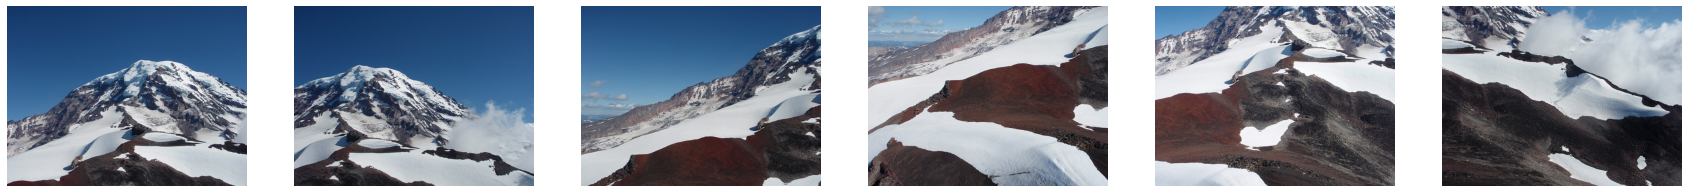

In [55]:
images_list = [cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB) for image_file in image_files_list]
fig, axs = plt.subplots(1, 6, figsize=(30, 8))
for ax, img in zip(axs, images_list):
    ax.imshow(img)
    ax.axis('off')

In [56]:
#Pasar Imagenes a gris y poner en un background negro

image1 = 'images/Rainier1.png'
image2 = 'images/Rainier2.png'
image3 = 'images/Rainier3.png'
image4 = 'images/Rainier4.png'
image5 = 'images/Rainier5.png'
image6 = 'images/Rainier6.png'

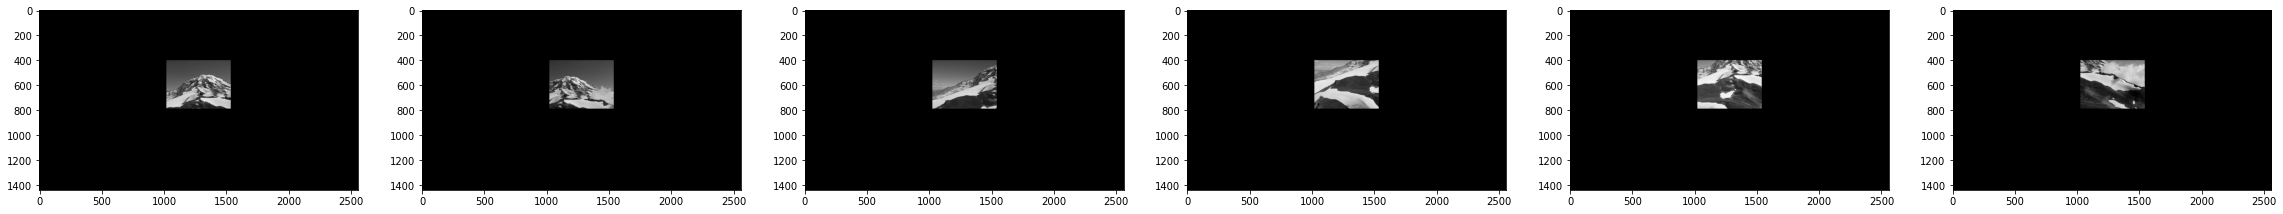

In [57]:
img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img1.shape[0] // 2:img_aux.shape[0] // 2 -125+ img1.shape[0] // 2,
img_aux.shape[1] // 2 - img1.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img1.shape[1] // 2] = img1
img1 = img_aux

img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img2.shape[0] // 2:img_aux.shape[0] // 2 -125+ img2.shape[0] // 2,
img_aux.shape[1] // 2 - img2.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img2.shape[1] // 2] = img2
img2 = img_aux

img3 = cv2.imread(image3, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img3.shape[0] // 2:img_aux.shape[0] // 2 -125+ img3.shape[0] // 2,
img_aux.shape[1] // 2 - img3.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img3.shape[1] // 2] = img3
img3 = img_aux

img4 = cv2.imread(image4, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img4.shape[0] // 2:img_aux.shape[0] // 2 -125+ img4.shape[0] // 2,
img_aux.shape[1] // 2 - img4.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img4.shape[1] // 2] = img4
img4 = img_aux

img5 = cv2.imread(image5, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img5.shape[0] // 2:img_aux.shape[0] // 2 -125+ img5.shape[0] // 2,
img_aux.shape[1] // 2 - img5.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img5.shape[1] // 2] = img5
img5 = img_aux

img6 = cv2.imread(image6, cv2.IMREAD_GRAYSCALE)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux[img_aux.shape[0] // 2 -125- img6.shape[0] // 2:img_aux.shape[0] // 2 -125+ img6.shape[0] // 2,
img_aux.shape[1] // 2 - img6.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img6.shape[1] // 2] = img6
img6 = img_aux

plt.figure(figsize=(40, 20))
plt.subplot(1, 6, 1)
plt.imshow(img1, cmap='gray')
plt.subplot(1, 6, 2)
plt.imshow(img2, cmap='gray')
plt.subplot(1, 6, 3)
plt.imshow(img3, cmap='gray')
plt.subplot(1, 6, 4)
plt.imshow(img4, cmap='gray')
plt.subplot(1, 6, 5)
plt.imshow(img5, cmap='gray')
plt.subplot(1, 6, 6)
plt.imshow(img6, cmap='gray')
plt.show()

In [58]:
detector = cv2.SIFT_create()
kp1, des1 = detector.detectAndCompute(img1, None)
kp2, des2 = detector.detectAndCompute(img2, None)
kp3, des3 = detector.detectAndCompute(img3, None)
kp4, des4 = detector.detectAndCompute(img4, None)
kp5, des5 = detector.detectAndCompute(img5, None)
kp6, des6 = detector.detectAndCompute(img6, None)

Enontramos pares depuntos que tengan los descriptores mas parecidos, y que tengan correspondencia mutua

In [59]:
indices_2_1 = encontrar_pares(des1, des2) #primero tiene los indices de los kp1 con los indicies del kp2
indices_3_1 = encontrar_pares(des1, des3)
indices_4_3 = encontrar_pares(des3, des4)
indices_5_1 = encontrar_pares(des1, des5)
indices_6_2 = encontrar_pares(des2, des6)

Filtramos los pares que tengan una distancia menor a un umbral

In [60]:

indices_2_1 = filtrar_umbral(indices_2_1, des1, des2, 50)
indices_3_1 = filtrar_umbral(indices_3_1, des1, des3, 50)
indices_4_3 = filtrar_umbral(indices_4_3, des3, des4, 50)
indices_5_1 = filtrar_umbral(indices_5_1, des1, des5, 50)
indices_6_2 = filtrar_umbral(indices_6_2, des2, des6, 50)

Ahora tenemos que encontrar las homografias que transforma los puntos de una imagen a otra

In [61]:
M1=encontrar_Homografia(indices_2_1,kp2, kp1)
M1

array([[ 2.61967494e-01,  5.48777033e-02,  5.44548787e+02],
       [-1.96560092e-01,  6.73535201e-01,  2.19034210e+02],
       [-2.95177106e-04,  2.44708261e-05,  1.00000000e+00]])

In [62]:
M2=encontrar_Homografia(indices_3_1,kp3, kp1)
M2

C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


array([[ 1.21414718e+01, -1.82778355e+00, -8.20798542e+03],
       [ 3.00487799e+00,  5.69545951e+00, -3.09301557e+03],
       [ 4.71390842e-03, -1.59633962e-03,  9.99999914e-01]])

In [63]:
M3=encontrar_Homografia(indices_4_3,kp4, kp3)
M3

array([[ 1.12402679e+00, -5.46861125e-01,  5.43622807e+00],
       [ 8.94629596e-02,  6.49087659e-01,  1.90256095e+02],
       [ 1.39194298e-04, -4.43535462e-04,  1.00000000e+00]])

In [64]:
M4=encontrar_Homografia(indices_5_1,kp5, kp1)
M4

C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


array([[ 9.16774565e-01, -5.70592770e-01,  1.72846182e+02],
       [ 3.30919836e-02,  5.26634038e-01,  2.70833599e+02],
       [ 5.86391278e-05, -4.59660962e-04,  1.00000000e+00]])

In [65]:
M5=encontrar_Homografia(indices_6_2,kp6, kp2)
M5

C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\germa\PycharmProjects\obligatorio-cv\venv\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


array([[ 2.22409256e-01, -4.26962167e-01,  6.87304018e+02],
       [-1.87434362e-01,  3.16930842e-01,  4.53948845e+02],
       [-2.41237902e-04, -3.29018461e-04,  1.00000000e+00]])

In [66]:
img1_color = cv2.imread(image1, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img1_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img1_color.shape[0] // 2,
img_aux.shape[1] // 2 - img1_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img1_color.shape[1] // 2] = img1_color
img1_color = img_aux

img2_color = cv2.imread(image2, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img2_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img2_color.shape[0] // 2,
img_aux.shape[1] // 2 - img2_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img2_color.shape[1] // 2] = img2_color
img2_color = img_aux

img3_color = cv2.imread(image3, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img3_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img3_color.shape[0] // 2,
img_aux.shape[1] // 2 - img3_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img3_color.shape[1] // 2] = img3_color
img3_color = img_aux

img4_color = cv2.imread(image4, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img4_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img4_color.shape[0] // 2,
img_aux.shape[1] // 2 - img4_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img4_color.shape[1] // 2] = img4_color
img4_color = img_aux

img5_color = cv2.imread(image5, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img5_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img5_color.shape[0] // 2,
img_aux.shape[1] // 2 - img5_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img5_color.shape[1] // 2] = img5_color
img5_color = img_aux

img6_color = cv2.imread(image6, cv2.COLOR_BGR2RGB)
img_aux = np.zeros((1440, 2560), dtype=np.uint8)
img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
img_aux[img_aux.shape[0] // 2 -125- img6_color.shape[0] // 2:img_aux.shape[0] // 2 -125+ img6_color.shape[0] // 2,
img_aux.shape[1] // 2 - img6_color.shape[1] // 2:img_aux.shape[1] // 2 + 1 + img6_color.shape[1] // 2] = img6_color
img6_color = img_aux

In [67]:
dst2 = cv2.warpPerspective(img2, M1, (img2.shape[1], img2.shape[0]))
dst3 = cv2.warpPerspective(img3, M2, (img2.shape[1], img2.shape[0]))
dst4 = cv2.warpPerspective(img4, np.dot(M2, M3), (img2.shape[1], img2.shape[0]))
dst5 = cv2.warpPerspective(img5, M4, (img2.shape[1], img2.shape[0]))
dst6 = cv2.warpPerspective(img6, np.dot(M1, M5), (img2.shape[1], img2.shape[0]))

dst2c = cv2.warpPerspective(img2_color, M1, (img2.shape[1], img2.shape[0]))
dst3c = cv2.warpPerspective(img3_color, M2, (img2.shape[1], img2.shape[0]))
dst4c = cv2.warpPerspective(img4_color, np.dot(M2, M3), (img2.shape[1], img2.shape[0]))
dst5c = cv2.warpPerspective(img5_color, M4, (img2.shape[1], img2.shape[0]))
dst6c = cv2.warpPerspective(img6_color, np.dot(M1, M5), (img2.shape[1], img2.shape[0]))


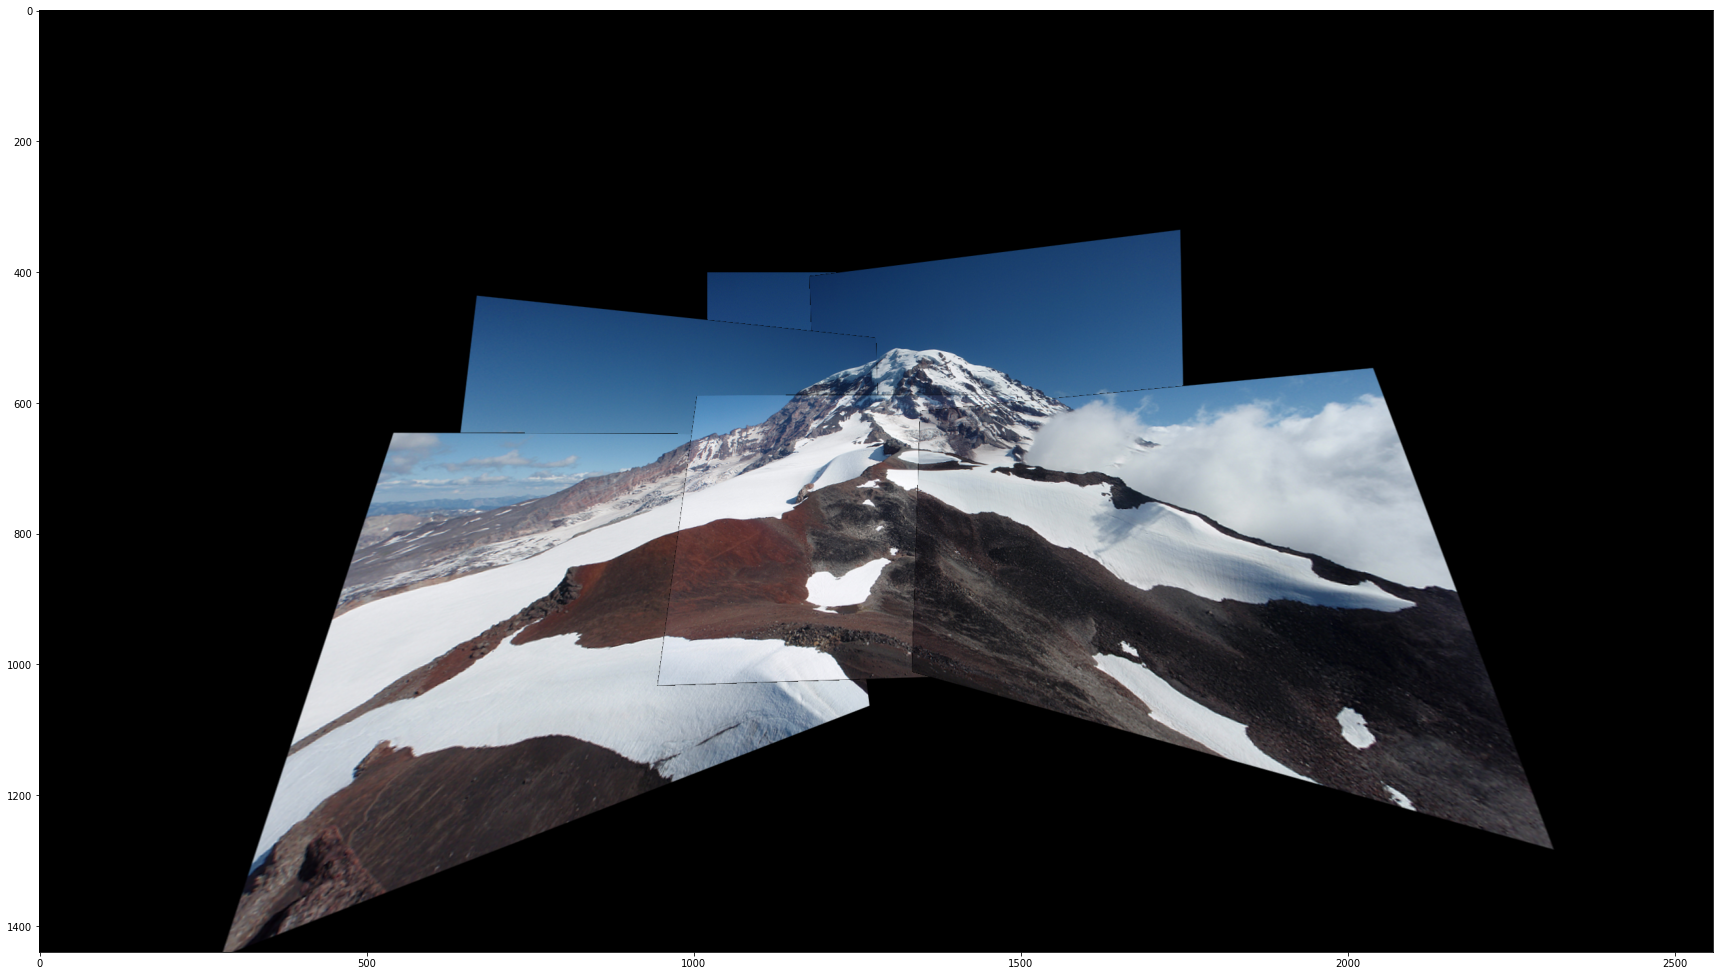

In [68]:

mask2 = ~(dst2 > 0)
mask3 = ~(dst3 > 0)
mask4 = ~(dst4 > 0)
mask5 = ~(dst5 > 0)
mask6 = ~(dst6 > 0)

masked = cv2.bitwise_and(img1_color, img1_color, mask=mask2.astype(np.uint8))
stitch = dst2c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask3.astype(np.uint8))
stitch = dst3c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask4.astype(np.uint8))
stitch = dst4c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask5.astype(np.uint8))
stitch = dst5c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask6.astype(np.uint8))
stitch = dst6c + masked

stitch = cv2.cvtColor(stitch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30, 30))
plt.imshow(stitch)
plt.show()